# 프로젝트 1

## 프로젝트 1-1

In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from skimage import data
import matplotlib.pyplot as plt

In [26]:
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)
def preprocessing(lr, hr):
    hr = tf.cast(hr, tf.float32) /255.
        
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])
        
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄입니다
    # 이렇게 만든 저해상도 이미지를 SRGAN의 입력으로 사용합니다.
    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], "bicubic")
    return lr_patch, hr_patch

train = train.map(preprocessing).shuffle(buffer_size=10).repeat().batch(8)
valid = valid.map(preprocessing).repeat().batch(8)
print("✅")

✅


In [27]:
from tensorflow.keras import Input, Model

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

print("✅")

✅


In [28]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

print("✅")

✅


In [29]:
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

print("✅")

✅


In [30]:
from tensorflow.keras import losses, metrics, optimizers

generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)


@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)
    
    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)
        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(train):
        g_loss, d_loss = step(lr, hr)
        
        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)
        
        # 10회 반복마다 loss를 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")
        
        if (i+1) == 200:
            break
            
    gene_losses.reset_states()
    disc_losses.reset_states()

NameError: name 'layers' is not defined

In [31]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [32]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr)
print("✅")

✅


### 1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

(675, 900, 3)


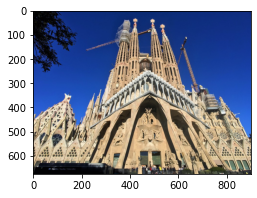

In [53]:
hr_image = os.getenv('HOME')+'/aiffel/super_resolution/sagrada.jpeg' # skimage에서 제공하는 예제 이미지를 불러옵니다.
img_orig = cv2.imread(hr_image)
resized_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
img_orig = resized_rgb

print(img_orig.shape) # 이미지의 크기를 출력합니다.

plt.figure(figsize=(6,3))
plt.imshow(img_orig)

### 2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.

[[[  2   2   4]
  [  1   1   3]
  [  1   1   3]
  ...
  [ 13  38 120]
  [ 11  35 117]
  [ 11  34 111]]

 [[  4   4   6]
  [  2   2   4]
  [  1   1   3]
  ...
  [ 14  41 123]
  [ 12  37 119]
  [ 14  34 114]]

 [[ 27  27  27]
  [ 20  20  20]
  [  2   2   2]
  ...
  [ 16  43 127]
  [ 14  41 125]
  [ 14  37 119]]

 ...

 [[137 140 116]
  [  4   5   2]
  [  1   3   2]
  ...
  [ 57  59  70]
  [ 56  56  74]
  [ 49  53  61]]

 [[ 97  98  78]
  [  3   3   8]
  [  1   2   3]
  ...
  [ 47  45  63]
  [ 28  29  34]
  [ 32  33  40]]

 [[  3   3   4]
  [  3   3   7]
  [  2   2   4]
  ...
  [ 36  43  51]
  [ 38  41  47]
  [ 21  24  30]]]


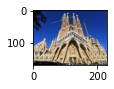

In [54]:
lr_image = cv2.resize(img_orig, dsize=(230,170))

print(lr_image)

plt.figure(figsize=(3,1))
plt.imshow(lr_image)

### 3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.

In [55]:
srgan_img = apply_srgan(lr_image)

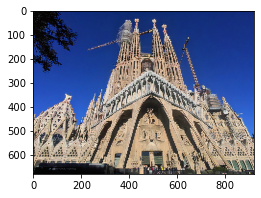

In [56]:
plt.figure(figsize=(6,3))
plt.imshow(srgan_img)

### 4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.

In [57]:
bicubic_image = cv2.resize(
    lr_image, 
    dsize=(850, 850), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

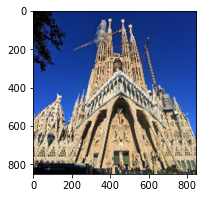

In [58]:
plt.figure(figsize=(6,3))
plt.imshow(bicubic_image)

for i, (lr, hr) in enumerate(valid):
    if i == 12: break # 12번째 이미지를 불러옵니다.

lr_img, hr_img = np.array(lr), np.array(hr)

# bicubic interpolation
bicubic_img = cv2.resize(
    lr_img, 
    (hr.shape[1], hr.shape[0]), 
    interpolation=cv2.INTER_CUBIC
)

# 전체 이미지를 시각화합니다.
plt.figure(figsize=(20,15))
plt.subplot(311); plt.imshow(hr_img)

# SRCNN을 이용해 고해상도로 변환합니다.
srcnn_img = apply_srcnn(bicubic_img)

# SRGAN을 이용해 고해상도로 변환합니다.
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srgan_img, img_orig]
titles = ["Bicubic", "SRGAN", "Orig"]

left_top = (700, 1090) # 잘라낼 부분의 왼쪽 상단 좌표를 지정합니다.

# bicubic, SRCNN, SRGAN 을 적용한 이미지와 원래의 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(20,20))
for i, pind in enumerate([321, 322, 323, 324]):
    plt.subplot(pind)
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i], fontsize=30)

### 5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.

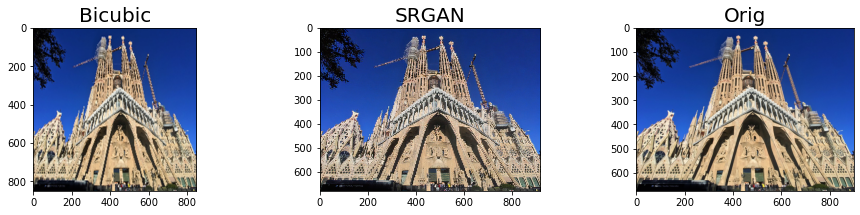

In [59]:
images = [bicubic_image, srgan_img, img_orig]
titles = ["Bicubic", "SRGAN", "Orig"]

left_top = (700, 1090) # 잘라낼 부분의 왼쪽 상단 좌표를 지정합니다.

# bicubic, SRCNN, SRGAN 을 적용한 이미지와 원래의 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

## 프로젝트 1-2

### 1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

(225, 225, 3)


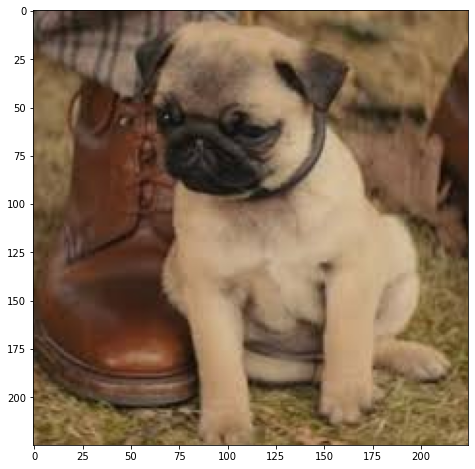

In [60]:
hr_image = os.getenv('HOME')+'/aiffel/super_resolution/JB.jpeg' # skimage에서 제공하는 예제 이미지를 불러옵니다.
img_orig = cv2.imread(hr_image)
resized_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
img_orig = resized_rgb

print(img_orig.shape) # 이미지의 크기를 출력합니다.

plt.figure(figsize=(12,8))
plt.imshow(img_orig)

### 2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.

In [61]:
srgan_img = apply_srgan(img_orig)

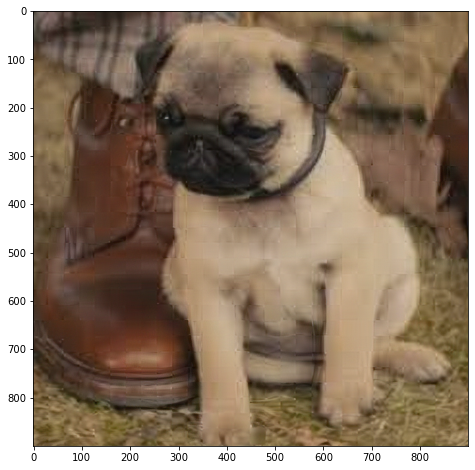

In [62]:
plt.figure(figsize=(12,8))
plt.imshow(srgan_img)

### 3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.

In [65]:
bicubic_image = cv2.resize(
    img_orig, 
    dsize=(850, 850), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

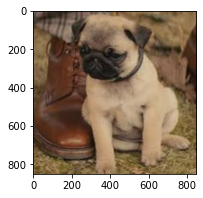

In [66]:
plt.figure(figsize=(6,3))
plt.imshow(bicubic_image)

### 4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.

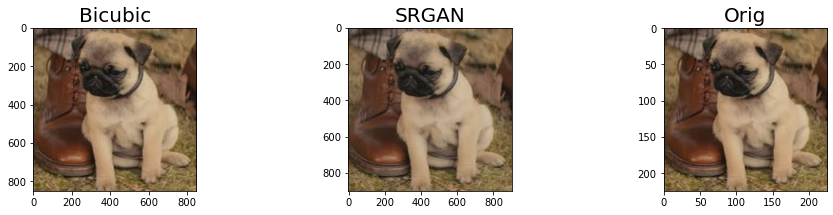

In [67]:
images = [bicubic_image, srgan_img, img_orig]
titles = ["Bicubic", "SRGAN", "Orig"]

left_top = (700, 1090) # 잘라낼 부분의 왼쪽 상단 좌표를 지정합니다.

# bicubic, SRCNN, SRGAN 을 적용한 이미지와 원래의 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

# 프로젝트 2

## 1. gif 파일 불러오기

In [70]:

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture(os.getenv('HOME')+'/aiffel/super_resolution/city_night_lr.gif')

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)
